SIFT + LBP + Cosine Similarity

1. Import & Dataset

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [30]:
DATA_DIR = "D:/Berkas/Code/Semester 7/temu_kembali_citra/archive (5)/Corel-1K/Corel-1K"       # Folder utama berisi 10 subfolder
OUTPUT_DIR = "output_csv"   # Folder output hasil split
FEATURE_OUTPUT_DIR = "features"  # Folder output hasil ekstraksi fitur

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_OUTPUT_DIR, exist_ok=True)


2. Split dataset menjadi Query (10%) dan Gallery (90%)

In [31]:
data = []
for class_name in sorted(os.listdir(DATA_DIR)):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                data.append({
                    "path": os.path.join(class_path, fname),
                    "label": class_name
                })

query_data, gallery_data = [], []
for class_name in sorted(os.listdir(DATA_DIR)):
    class_images = [d for d in data if d["label"] == class_name]
    if len(class_images) > 0:
        train, test = train_test_split(class_images, test_size=0.1, random_state=42)
        gallery_data.extend(train)
        query_data.extend(test)

print(f"✅ Total Query: {len(query_data)} | Gallery: {len(gallery_data)}")


✅ Total Query: 100 | Gallery: 900


3. Preprocessing dasar dan simpan hasil split

In [32]:
def basic_preprocess(img_path, output_dir):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))
        out_path = os.path.join(output_dir, os.path.basename(img_path))
        img.save(out_path)
        return out_path
    except Exception as e:
        print(f"⚠️ Error memproses {img_path}: {e}")
        return None

query_pre_dir = os.path.join(OUTPUT_DIR, "query_preprocessed")
gallery_pre_dir = os.path.join(OUTPUT_DIR, "gallery_preprocessed")
os.makedirs(query_pre_dir, exist_ok=True)
os.makedirs(gallery_pre_dir, exist_ok=True)

preprocessed_query = []
preprocessed_gallery = []

for item in tqdm(query_data, desc="Processing Query"):
    new_path = basic_preprocess(item["path"], query_pre_dir)
    if new_path:
        preprocessed_query.append({"path": new_path, "label": item["label"]})

for item in tqdm(gallery_data, desc="Processing Gallery"):
    new_path = basic_preprocess(item["path"], gallery_pre_dir)
    if new_path:
        preprocessed_gallery.append({"path": new_path, "label": item["label"]})

pd.DataFrame(preprocessed_query).to_csv(os.path.join(OUTPUT_DIR, "query.csv"), index=False)
pd.DataFrame(preprocessed_gallery).to_csv(os.path.join(OUTPUT_DIR, "gallery.csv"), index=False)

print("✅ Split dan preprocessing selesai!")


Processing Gallery: 100%|██████████| 900/900 [00:02<00:00, 371.32it/s]

✅ Split dan preprocessing selesai!


4. Preprocessing untuk SIFT + LBP

In [33]:
IMG_SIZE = (256, 256)
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

def preprocess_for_sift_lbp(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Gagal membaca gambar: {img_path}")
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    return img.astype(np.uint8)


5. Ekstraksi fitur SIFT

In [34]:
def extract_sift_features(gray_img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    if descriptors is None:
        return np.zeros(128)
    return np.mean(descriptors, axis=0)


6. Ekstraksi fitur LBP

In [35]:
def extract_lbp_features(gray_img):
    lbp = local_binary_pattern(gray_img, LBP_POINTS, LBP_RADIUS, method="uniform")
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist


7. Gabungkan fitur SIFT + LBP

In [36]:
def extract_combined_features(img_path):
    gray = preprocess_for_sift_lbp(img_path)
    sift_vec = extract_sift_features(gray)
    lbp_vec = extract_lbp_features(gray)
    combined = np.concatenate([sift_vec, lbp_vec])
    return combined


8. Ekstraksi fitur dari CSV dan simpan ke file

In [37]:
def extract_features_from_csv(csv_path, output_filename):
    df = pd.read_csv(csv_path)
    features, labels, paths = [], [], []

    print(f"🔍 Memproses {len(df)} gambar dari {csv_path} ...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = row["path"]
        label = row["label"]
        try:
            vec = extract_combined_features(img_path)
            features.append(vec)
            labels.append(label)
            paths.append(img_path)
        except Exception as e:
            print(f"⚠️ Gagal memproses {img_path}: {e}")

    feature_df = pd.DataFrame(features)
    feature_df["label"] = labels
    feature_df["path"] = paths
    out_path = os.path.join(FEATURE_OUTPUT_DIR, output_filename)
    feature_df.to_csv(out_path, index=False)
    print(f"✅ Fitur berhasil disimpan ke {out_path}")


In [38]:
extract_features_from_csv("output_csv/query.csv", "query_features.csv")
extract_features_from_csv("output_csv/gallery.csv", "gallery_features.csv")


🔍 Memproses 100 gambar dari output_csv/query.csv ...


100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


✅ Fitur berhasil disimpan ke features\query_features.csv
🔍 Memproses 900 gambar dari output_csv/gallery.csv ...


100%|██████████| 900/900 [00:37<00:00, 23.69it/s]


✅ Fitur berhasil disimpan ke features\gallery_features.csv


9. Load fitur dan hitung Cosine Similarity

In [39]:
QUERY_FEATURES_PATH = "features/query_features.csv"
GALLERY_FEATURES_PATH = "features/gallery_features.csv"

df_query = pd.read_csv(QUERY_FEATURES_PATH)
df_gallery = pd.read_csv(GALLERY_FEATURES_PATH)

feature_columns = [c for c in df_query.columns if c not in ["label", "path"]]

X_query = df_query[feature_columns].values
X_gallery = df_gallery[feature_columns].values

query_labels = df_query["label"].values
gallery_labels = df_gallery["label"].values
query_paths = df_query["path"].values
gallery_paths = df_gallery["path"].values

print(f"Query samples: {X_query.shape[0]} | Gallery samples: {X_gallery.shape[0]}")
print(f"Dimensi fitur: {X_query.shape[1]}")


Query samples: 100 | Gallery samples: 900
Dimensi fitur: 138


In [40]:
similarity_matrix = cosine_similarity(X_query, X_gallery)
print("✅ Cosine similarity matrix shape:", similarity_matrix.shape)


✅ Cosine similarity matrix shape: (100, 900)


In [55]:
def get_top_k_similar(query_index, top_k=5):
    sims = similarity_matrix[query_index]
    top_indices = np.argsort(sims)[::-1][:top_k]
    return [(gallery_paths[i], gallery_labels[i], sims[i]) for i in top_indices]


In [56]:
def show_retrieval_result(query_index, top_k=5):
    query_img_path = query_paths[query_index]
    query_label = query_labels[query_index]

    results = get_top_k_similar(query_index, top_k)

    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 4))
    fig.suptitle(f"Query: {os.path.basename(query_img_path)} ({query_label})", fontsize=14)

    query_img = Image.open(query_img_path)
    axes[0].imshow(query_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, (path, label, score) in enumerate(results):
        img = Image.open(path)
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{label}\n(sim={score:.3f})")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


🎲 Menampilkan 3 query acak:
[43, 86, 6]


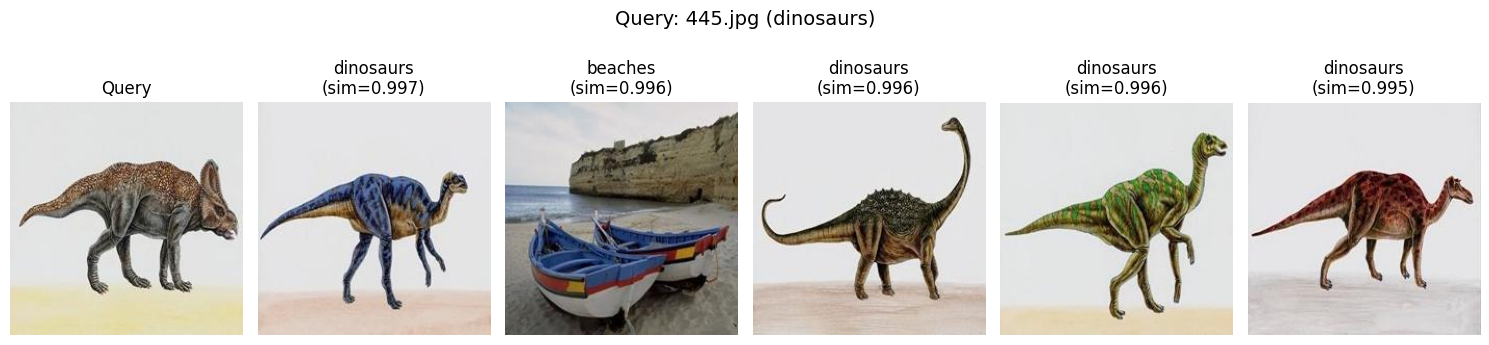

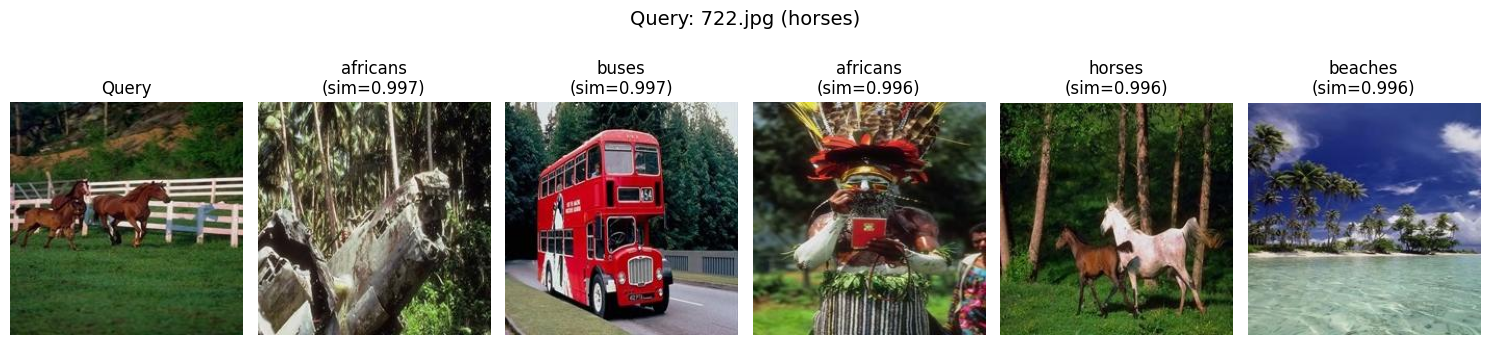

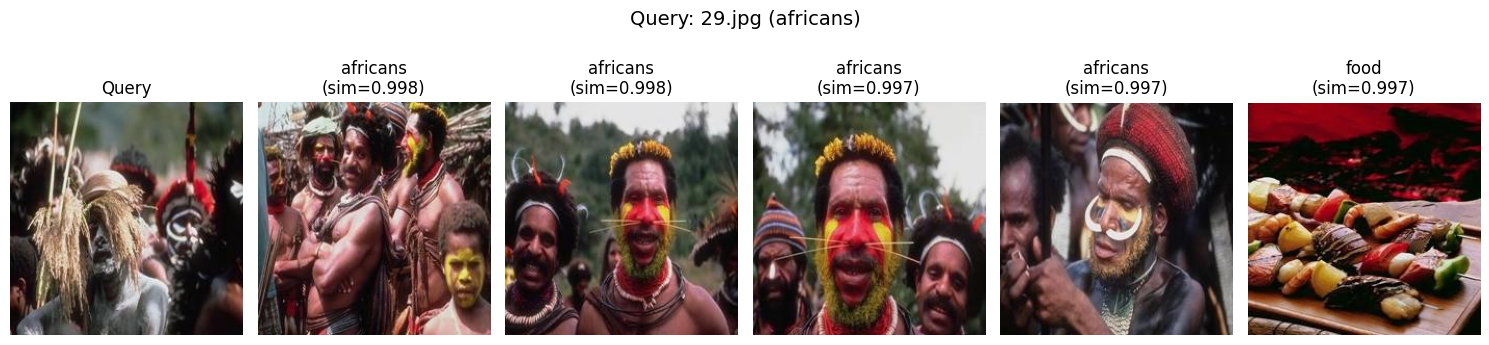

In [57]:
N_RANDOM_QUERIES = 3  

# Ambil indeks acak tanpa duplikasi
random_indices = random.sample(range(len(query_paths)), N_RANDOM_QUERIES)

print(f"🎲 Menampilkan {N_RANDOM_QUERIES} query acak:")
print(random_indices)

for idx in random_indices:
    show_retrieval_result(query_index=idx, top_k=5)


10. Evaluasi Top-K Accuracy dan mAP

In [59]:
def evaluate_retrieval(similarity_matrix, query_labels, gallery_labels, top_k_values=[1, 5, 10]):
    results = {}
    n_queries = len(query_labels)

    for k in top_k_values:
        correct = 0
        for i in range(n_queries):
            top_k_idx = np.argsort(similarity_matrix[i])[::-1][:k]
            top_k_labels = gallery_labels[top_k_idx]
            if query_labels[i] in top_k_labels:
                correct += 1
        results[f"Top-{k} Accuracy"] = correct / n_queries

    average_precisions = []
    for i in range(n_queries):
        sims = similarity_matrix[i]
        sorted_indices = np.argsort(sims)[::-1]
        sorted_labels = gallery_labels[sorted_indices]
        relevant = (sorted_labels == query_labels[i])
        if np.sum(relevant) == 0:
            continue
        precisions = []
        retrieved = 0
        correct = 0
        for rel in relevant:
            retrieved += 1
            if rel:
                correct += 1
                precisions.append(correct / retrieved)
        average_precisions.append(np.mean(precisions))

    results["mAP"] = np.mean(average_precisions)
    return results

eval_results = evaluate_retrieval(similarity_matrix, query_labels, gallery_labels)
print("📊 Evaluasi Retrieval Performance:")
for metric, score in eval_results.items():
    print(f"  {metric}: {score*100:.2f}%")


📊 Evaluasi Retrieval Performance:
  Top-1 Accuracy: 56.00%
  Top-5 Accuracy: 81.00%
  Top-10 Accuracy: 89.00%
  mAP: 32.26%


11. Evaluasi Precision, Recall, F1, dan Accuracy

In [58]:
def evaluate_precision_recall_f1(similarity_matrix, query_labels, gallery_labels, top_k=5):
    """
    Evaluasi retrieval menggunakan Precision, Recall, dan F1-score berbasis label.
    """
    y_true_all = []
    y_pred_all = []

    for i in range(len(query_labels)):
        sims = similarity_matrix[i]
        top_indices = np.argsort(sims)[::-1][:top_k]
        top_labels = gallery_labels[top_indices]

        # Label benar untuk query ini
        true_label = query_labels[i]

        # Buat vektor prediksi: 1 jika label sama, 0 jika beda
        y_true = np.array([1 if l == true_label else 0 for l in top_labels])
        y_pred = np.ones_like(y_true)  # karena semua hasil dianggap "retrieved"

        # Simpan semua hasil untuk agregasi global
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)

    # Hitung metrik
    precision = precision_score(y_true_all, y_pred_all, zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, zero_division=0)
    accuracy = accuracy_score(y_true_all, y_pred_all)

    return {
        "Top-K": top_k,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Accuracy": accuracy
    }


# 🔍 Jalankan evaluasi dengan Top-5 misalnya
eval_prf = evaluate_precision_recall_f1(similarity_matrix, query_labels, gallery_labels, top_k=5)

print("📊 Evaluasi Precision / Recall / F1 untuk Top-5 Retrieval:")
for k, v in eval_prf.items():
    if k != "Top-K":
        print(f"  {k}: {v*100:.2f}%")


📊 Evaluasi Precision / Recall / F1 untuk Top-5 Retrieval:
  Precision: 49.80%
  Recall: 100.00%
  F1-score: 66.49%
  Accuracy: 49.80%
